In [0]:
#install Modedules
!pip install --upgrade pip
!pip install -U -q PyDrive
!pip install -U -q pydotplus
!pip install -U -q graphviz
!pip install -U imbalanced-learn

In [0]:
#suppress warnings : https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

from collections import Counter

from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import VotingClassifier

from imblearn.datasets import make_imbalance
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler, NearMiss,InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,EditedNearestNeighbours, RepeatedEditedNearestNeighbours,
                                     AllKNN, NeighbourhoodCleaningRule, OneSidedSelection)
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.metrics import (classification_report, average_precision_score, matthews_corrcoef, hamming_loss,
                             accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score,
                            confusion_matrix, cohen_kappa_score)

import seaborn as sn
import itertools 
from sklearn import preprocessing

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

#CONSTANTS
DATA_FRAC_NORMAL = 1.0
DATA_FRAC_FOR_INC = DATA_FRAC_NORMAL

CV_SPLITS = 1
TEST_FRAC = 0.2

In [0]:
def normalize(X):
    # Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X
  
def normalize_0(X):
    # Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    result = X.copy()
    for feature in X.columns:
        result[feature] -= X[feature].mean()
        result[feature] /= result[feature].std()
    return result
  
def normalize_1(X):
    result = X.copy()
    for feature_name in X.columns:
        max_value = X[feature_name].max()
        min_value = X[feature_name].min()
        result[feature_name] = (X[feature_name] - min_value) / (max_value - min_value)
    return result
  
def standardize(X):
  # Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
  scaler = preprocessing.StandardScaler()
  scaled_X = scaler.fit_transform(X)
  return pd.DataFrame(scaled_X, columns = X.columns)
  
from google.colab import files
def download_dfResults(df_name, csv_name):
  df_name.to_csv(csv_name)
  files.download(csv_name)
  
def plot_fraud_conf_mat_both(confusion_mat, title):   
    sn.set(font_scale=1.0) # label size    
    fig, ax = plt.subplots(figsize=(3.3,1.5), ncols=2, nrows=1, sharey='row')
    plt.suptitle(title , y = 1.03, fontsize=13)

    df_cm = pd.DataFrame(confusion_mat, index = [0,1], columns = [0,1])
    sn.heatmap(df_cm, ax=ax[0], annot=True, cbar=False, cmap=plt.cm.Blues, fmt='g')
    #ax[0].set_title('Original')
    ax[0].set_ylabel('Actual')
    ax[0].set_xlabel('Prediction\nOriginal')
    
    confusion_mat_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    df_cm_normalized = pd.DataFrame(confusion_mat_normalized, index = [0,1], columns = [0,1])
    sn.heatmap(df_cm_normalized, ax=ax[1], annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.4f') #g  .1f, .2f
    #ax[1].set_title('Normalized')
    #ax[1].set_ylabel('Actual')
    ax[1].set_xlabel('Prediction\nNormalized')
    
    plt.show()


def plot_fraud_conf_mat(confusion_mat, title, normalize_confusion_mat = True):
    confusion_mat = results.copy()
    
    plt.figure(figsize = (1.5,1.5))        
    sn.set(font_scale=1.0) # label size
    plt.title(title)
    
    if normalize_confusion_mat:
        confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]        
        sn.heatmap(confusion_mat, annot=True, cbar=False, cmap=plt.cm.Blues , fmt='.4f') 
        plt.xlabel('Prediction (Norm)')
    else:
        sn.heatmap(confusion_mat, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='g') 
        plt.xlabel('Prediction')
    plt.ylabel('Actual')
    
    
def Generic_Model(model_disc, sampler_disc, dataset_disc, model, sampler , _X, _y, dfResults, n_splits = 1, test_size = 0.2, random_state = 41):
    start_time = time.time()
    splitter = StratifiedShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    average_precision_scores = []
    G_mean_scores = []
    AUC_scores = []
    cohen_kappa_scores = []
    matthews_corrcoef_scores = []
    hamming_loss_scores = []
    confusion_mat_comb = np.array([[0, 0], [0, 0]])
    confusion_mat_n = 0

    for train_indices, test_indices in splitter.split(_X, _y):
        X_train, y_train = _X.iloc[train_indices], _y.iloc[train_indices]
        X_test, y_test = _X.iloc[test_indices], _y.iloc[test_indices]        

        # Normalize the data
        X_train_norm = standardize(X_train)
        X_test_norm = standardize(X_test)

        # Fit and predict!
        if( sampler == 'NO_SAMPLER'):
          model.fit(X_train_norm, y_train)
          y_pred = model.predict(X_test_norm) #.astype(int)  <<------We only use Classifiers. Else Need to set a cut off (y_pred>threshold).astype(int)
        else:
          pipeline = make_pipeline(sampler, model)
          pipeline.fit(X_train_norm, y_train)
          y_pred = pipeline.predict(X_test_norm) #.astype(int)  # <<-----

        #print('______________' , disc , '_____________')
        #print(classification_report(y_test, y_pred))    
        """Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). 
        Confusion matrix accuracy is not meaningful for unbalanced classification."""
        #https://nycdatascience.com/blog/student-works/credit-card-fraud-detection/
        #http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py        
        #print(disc, 'Average precision-recall score: {0:0.2f}'.format(average_precision))        
        #https://machinelearningmastery.com/assessing-comparing-classifier-performance-roc-curves-2/
              
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred)) #, average='micro'))  #<<<<<<<<<------- added:average='micro'
        recall_scores.append(recall_score(y_test, y_pred)) #, average='micro'))  #<<<<<<<<<------- added:average='micro'
        f1_scores.append(f1_score(y_test, y_pred)) #, average='micro'))  #<<<<<<<<<------- added:average='micro'
        average_precision_scores.append(average_precision_score(y_test, y_pred))
        #http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.metrics.geometric_mean_score.html
        ###########
        confusion_mat = confusion_matrix(y_test, y_pred)      
        confusion_mat_comb = confusion_mat_comb + confusion_mat
        confusion_mat_n = confusion_mat_n + 1
        
        tn, fp, fn, tp = confusion_mat.ravel()
        sensitivity_TPR = tp/(tp + fn)
        specificity_TNR = tn/(tn + fp)
        G_mean_scores.append(np.sqrt(sensitivity_TPR * specificity_TNR))
        ########### Accuracy check
        #count_classes = pd.value_counts(y_test)
        #print("count_classes: " , count_classes)
        #print("-------", tn, fp, fn, tp)
        #from sklearn.metrics import precision_recall_fscore_support
        #_, recall, _, _ = precision_recall_fscore_support(y_test, y_pred)
        #print("recall: ", recall) #should be the normalized conf_mat diagonal \
        ###########
        AUC_scores.append(roc_auc_score(y_test, y_pred))
        cohen_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
        matthews_corrcoef_scores.append(matthews_corrcoef(y_test, y_pred))
        hamming_loss_scores.append(hamming_loss(y_test, y_pred))

    elapsed_time = time.time() - start_time    
    tn, fp, fn, tp = np.around(confusion_mat_comb/confusion_mat_n, decimals=3).ravel()  #'TN', 'FP', 'FN', 'TP', 
    
    dfResults.loc[len(dfResults)]=[model_disc, sampler_disc, dataset_disc,
      '{:0.0f}'.format(tn),
      '{:0.0f}'.format(fp),
      '{:0.0f}'.format(fn),
      '{:0.0f}'.format(tp),
      '{0:0.4f}'.format(np.mean(accuracy_scores)),
      '{0:0.4f}'.format(np.mean(precision_scores)),
      '{0:0.4f}'.format(np.mean(recall_scores)),
      '{0:0.4f}'.format(np.mean(f1_scores)), 
      '{0:0.4f}'.format(np.mean(average_precision_scores)),
      '{0:0.4f}'.format(np.mean(G_mean_scores)), 
      '{0:0.4f}'.format(np.mean(AUC_scores)),
      '{0:0.4f}'.format(np.mean(cohen_kappa_scores)),
      '{0:0.4f}'.format(np.mean(matthews_corrcoef_scores)),
      '{0:0.4f}'.format(np.mean(hamming_loss_scores)),
      '{0:0.4f}'.format(elapsed_time)] 
    print(model_disc,',', sampler_disc,',', dataset_disc,
      ',{:0.0f}'.format(tn),
      ',{:0.0f}'.format(fp),
      ',{:0.0f}'.format(fn),
      ',{:0.0f}'.format(tp),
      ',{0:0.4f}'.format(np.mean(accuracy_scores)),
      ',{0:0.4f}'.format(np.mean(precision_scores)),
      ',{0:0.4f}'.format(np.mean(recall_scores)),
      ',{0:0.4f}'.format(np.mean(f1_scores)), 
      ',{0:0.4f}'.format(np.mean(average_precision_scores)),
      ',{0:0.4f}'.format(np.mean(G_mean_scores)),
      ',{0:0.4f}'.format(np.mean(AUC_scores)),
      ',{0:0.4f}'.format(np.mean(cohen_kappa_scores)),
      ',{0:0.4f}'.format(np.mean(matthews_corrcoef_scores)),
      ',{0:0.4f}'.format(np.mean(hamming_loss_scores)),
      ',{0:0.4f}'.format(elapsed_time) )
    return model, np.around(confusion_mat_comb/confusion_mat_n, decimals=3)  

In [0]:
DATASET_KAGGLE = 1
DATASET_UCI = 2

def get_dataset(dataset_id, n_frac = 1.0, fraud_frac = 1.0, frauds_to_drop = 0, encode_pca = True, random_state = 41):  # return X,y
  #source:https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  if ( dataset_id == DATASET_KAGGLE): #https://drive.google.com/open?id=1AqXlS0nkaR6c1QTwlAh3_oc3xflIIl0A
    if encode_pca == False:
        print('Error:PCA=False not possible for ID:', dataset_id )
        return  
    data_import = drive.CreateFile({'id':'1AqXlS0nkaR6c1QTwlAh3_oc3xflIIl0A'})  
    data_import.GetContentFile('Kaggle_creditcardfraud.zip')  
    zip_ref = zipfile.ZipFile('Kaggle_creditcardfraud.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    df_data = pd.read_csv('creditcard.csv', sep=',')    
  elif ( dataset_id == DATASET_UCI):   # https://drive.google.com/open?id=1hlW8cHAOvKTi6hqqkMuGfO9Z7QzFYWws     
    data_import = drive.CreateFile({'id':'1hlW8cHAOvKTi6hqqkMuGfO9Z7QzFYWws'})  
    data_import.GetContentFile('UCI_default_of_credit_card_clients_1.zip')  
    zip_ref = zipfile.ZipFile('UCI_default_of_credit_card_clients_1.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    df_data = pd.read_csv('UCI_default_of_credit_card_clients_1.csv', sep=',')
  else:
    print('Error:Unknown Dataset ID:', dataset_id )
    return
  
  if (n_frac != 1.0):
    df_data = df_data.sample(frac=n_frac, replace=True, random_state=random_state)
    
  if (frauds_to_drop != 0):
    df_data = df_data.sort_values(by=['Class'])[0 : int(len(df_data) - frauds_to_drop )].reset_index(drop=True)
    
  if ( dataset_id == DATASET_KAGGLE):  
    features = ['Time','Amount'] + ['V%d' % number for number in range(1, 29)]           
    target = 'Class'
    X = df_data[features]
    y = df_data[target]
  elif ( dataset_id == DATASET_UCI):
    # Convert UCI_default_of_credit_card_clients_1 to required format
    X_features = df_data[  ['X%d' % number for number in range(1, 23 + 1)] ]
    if encode_pca:    
        pca = PCA(n_components = 23, svd_solver='full')
        df_data_2 = pd.DataFrame( pca.fit_transform(standardize(X_features)), columns=['V%d' % number for number in range(1, 23 + 1)])
    else:
        df_data_2 = pd.DataFrame( standardize(X_features)).rename(columns=lambda x: 'V' + x[1:], inplace=False)

    df_data_2['Class'] = df_data['Class']

    features = ['V%d' % number for number in range(1, 23 + 1)]           
    target = 'Class'

    X = df_data_2[features]
    y = df_data_2[target]
  else:
    print('Error:Unknown Dataset ID:', dataset_id )
    return
  
  count_classes = pd.value_counts(df_data.Class)
  print("Loaded data :", df_data.shape, "  fract:", n_frac)      
  print(count_classes)
  
  return X,y

# **Models**

---



---



In [0]:
models_t = {'Dummy' : DummyClassifier(strategy='constant', constant=1),
          'LR': LogisticRegression()}
          
          
models = {'Dummy' : DummyClassifier(strategy='constant', constant=1),
          #https://www.data-blogger.com/2017/06/15/fraud-detection-a-simple-machine-learning-approach/
          'LR': LogisticRegression(),
          'RF': RandomForestClassifier(), 
          'GNB': GaussianNB(),

          'Ada_Real' : AdaBoostClassifier(algorithm='SAMME.R'), # real boosting algorithm
          'Ada_Disc' : AdaBoostClassifier(algorithm='SAMME'), # discrete boosting algorithm

          'GBC' : GradientBoostingClassifier(),

          'SVC_Linear': SVC(kernel="linear", C=0.025),
          #######'SVC_RBF': SVC(gamma=2, C=1), # Takes too long
          #######'GaussianProcessClassifier': GaussianProcessClassifier(1.0 * RBF(1.0)), # Crashes Runtime
          'NN_MLP':  MLPClassifier(alpha=1),  #Multi-layer Perceptron classifier
          'QuadraticDA': QuadraticDiscriminantAnalysis(),

          'Ridge' : RidgeClassifier(),

          #https://www.kaggle.com/jonmarty/predicting-credit-fraud-with-scikit-learn-methods
          'DT': DecisionTreeClassifier(),
          'SGD': SGDClassifier(),
          'PAClassifier': PassiveAggressiveClassifier(),
          'Perceptron' : Perceptron(),
          'KNN': KNeighborsClassifier()}

m0 = {'KNN': KNeighborsClassifier()}

In [0]:
def get_dfResults():
  df_Results = pd.DataFrame(columns=['Model' , 'Sampler' , 'Dataset', 'TN', 'FP', 'FN', 'TP', 
                                  'Accuracy', 'Precision','Recall', 'F1', 'Avg_prec', 'G-mean', 'AUROC', 'Cohen_kappa', 'Matthew', 'Hamming', 'Time'  ])
  pd.set_option('display.max_colwidth', -1)
  return df_Results

def runTest_set_with(dataset_disc, sampler_disc, sampler, model_set, X, y, dfResults, plot_conf_mat = False ):
  for key_disc,value_model in model_set.items():
    model, cnf_matrix = Generic_Model(key_disc, sampler_disc , dataset_disc, value_model, sampler , X, y, dfResults, n_splits=CV_SPLITS, test_size=TEST_FRAC)
    if plot_conf_mat:
      plot_fraud_conf_mat_both(cnf_matrix,'{} -{} -{}'.format(key_disc, sampler_disc ,dataset_disc))
      
def documentSampler(X_, y_, desc, sampler):
    X_sample, y_sample = sampler.fit_sample(X_, y_)
    print('Sampler: {} : {} ::  {}'.format(desc, Counter(y_), Counter(y_sample)))
    return sampler
#_____________________UnderSample : RandomUnderSampler, CondensedNearestNeighbour, InstanceHardnessThreshold
#sampler = documentSampler(X[:10000], y[:10000], 'RandomUnderSampler',  RandomUnderSampler(random_state=0) ) #({0: 9962, 1: 38})-({0: 38, 1: 38})
#sampler = documentSampler(X[:10000], y[:10000], 'CondensedNearestNeighbour',  CondensedNearestNeighbour(random_state=0) )#({0: 9962, 1: 38})-({0: 139, 1: 38})
#sampler = documentSampler(X[:10000], y[:10000], 'InstanceHardnessThreshold',  InstanceHardnessThreshold(random_state=0) )#({0: 9962, 1: 38})-({0: 9916, 1: 38})
#_____________________OverSample : ADASYN(random_state=0) RandomOverSampler(random_state=0), SMOTE(random_state=0)
#http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/applications/plot_over_sampling_benchmark_lfw.html#sphx-glr-auto-examples-applications-plot-over-sampling-benchmark-lfw-py
#sampler = documentSampler(X[:10000], y[:10000], 'ADASYN',  ADASYN(random_state=0) ) #({0: 9962, 1: 38})-({1: 9973, 0: 9962})
#sampler = documentSampler(X[:10000], y[:10000], 'RandomOverSampler',  RandomOverSampler(random_state=0) )#({0: 9962, 1: 38}) -({0: 9962, 1: 9962})
#sampler = documentSampler(X[:10000], y[:10000], 'SMOTE',  SMOTE(random_state=0) )#({0: 9962, 1: 38})-({0: 9962, 1: 9962})


In [0]:
#---KAGGLE Dataset--------------------------------------------------------------
dfResults = get_dfResults()
model_set = models   #models_t

# All-features, Unbalanced
#X,y = get_dataset(DATASET_KAGGLE, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = True, random_state = 41)
#runTest_set_with('KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), 'UB', 'NO_SAMPLER', model_set,X,y,dfResults)

# Incremental-features, Unbalanced
X_all_feat, y_inc_feat = get_dataset(DATASET_KAGGLE, n_frac = DATA_FRAC_FOR_INC, frauds_to_drop = 0, encode_pca = True, random_state = 41)

for var_limit in range(1,29):  #1..29
  features = ['Time','Amount'] + ['V%d' % number for number in range(1, var_limit + 1)]
  X_inc_feat = X_all_feat[features]
  
  print('\n___________________________Time Amount...V{}'.format(var_limit))
  #print('.',var_limit, end="", flush=True) #Append to line
  runTest_set_with('KA_{0:0.2f}_V{1:02d}'.format(DATA_FRAC_NORMAL,var_limit), 'UB', 'NO_SAMPLER', model_set,X_inc_feat, y_inc_feat, dfResults)

# Balanced
runTest_set_with('KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), 'U:RandomUnder', RandomUnderSampler(random_state=0), model_set,X,y,dfResults)
runTest_set_with('KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), 'U:InstHardThres', InstanceHardnessThreshold(random_state=0), model_set,X,y,dfResults)

runTest_set_with('KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), 'O:RandomOver', RandomOverSampler(random_state=0), model_set,X,y,dfResults)
runTest_set_with('KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), 'O:ADASYN', ADASYN(random_state=0), model_set,X,y,dfResults)
runTest_set_with('KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), 'O:SMOTE', SMOTE(random_state=0), model_set,X,y,dfResults)

# Ensembles
pclf_rf_overRandom = make_pipeline(RandomOverSampler(random_state=0), RandomForestClassifier())
pclf_rf_overSMOTE = make_pipeline(SMOTE(random_state=0), RandomForestClassifier())
pclf_rf_overInst = make_pipeline(InstanceHardnessThreshold(random_state=0), RandomForestClassifier())

hard_voting_clf = VotingClassifier(
    estimators=[('pclf_rf_overRandom', pclf_rf_overRandom), 
                ('pclf_rf_overSMOTE', pclf_rf_overSMOTE), 
                ('pclf_rf_overInst', pclf_rf_overInst)], 
    voting='hard')

soft_voting_clf = VotingClassifier(
    estimators=[('pclf_rf_overRandom', pclf_rf_overRandom),  
                ('pclf_rf_overSMOTE', pclf_rf_overSMOTE), 
                ('pclf_rf_overInst', pclf_rf_overInst)], 
    voting='soft')

Generic_Model('Vote:Hard', 'UB', 'KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), hard_voting_clf, 'NO_SAMPLER' , X, y, dfResults)
Generic_Model('Vote:Soft', 'UB', 'KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), soft_voting_clf, 'NO_SAMPLER' , X, y, dfResults)

dfResults.sort_values('F1', ascending=False).head(15)
download_dfResults(dfResults, 'KA_{0:0.2f}_V28.csv'.format(DATA_FRAC_NORMAL))  

In [0]:
#---KAGGLE Dataset-----------ENSEMBLE-------------------------------------------
dfResults = get_dfResults()
X,y = get_dataset(DATASET_KAGGLE, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = True, random_state = 41)

# Ensembles
pclf_rf_overRandom = make_pipeline(RandomForestClassifier())
pclf_rf_overSMOTE = make_pipeline(SMOTE(random_state=0), RandomForestClassifier())
pclf_rf_overInst = make_pipeline(InstanceHardnessThreshold(random_state=0), RandomForestClassifier())

hard_voting_clf = VotingClassifier(
    estimators=[('pclf_rf_overRandom', pclf_rf_overRandom), 
                ('pclf_rf_overSMOTE', pclf_rf_overSMOTE), 
                ('pclf_rf_overInst', pclf_rf_overInst)], 
    voting='hard')

soft_voting_clf = VotingClassifier(
    estimators=[('pclf_rf_overRandom', pclf_rf_overRandom),  
                ('pclf_rf_overSMOTE', pclf_rf_overSMOTE), 
                ('pclf_rf_overInst', pclf_rf_overInst)], 
    voting='soft')

Generic_Model('Vote:Hard', 'UB', 'KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), hard_voting_clf, 'NO_SAMPLER' , X, y, dfResults)
Generic_Model('Vote:Soft', 'UB', 'KA_{0:0.2f}_V28'.format(DATA_FRAC_NORMAL), soft_voting_clf, 'NO_SAMPLER' , X, y, dfResults)

In [0]:
#---UCI Dataset-----------------------------------------------------------------
dfResults = get_dfResults()
model_set = models   #models_t

# All-features, Unbalanced
X,y = get_dataset(DATASET_UCI, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = False, random_state = 41)
runTest_set_with('UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), 'UB', 'NO_SAMPLER', model_set,X,y,dfResults)

# Incremental-features, Unbalanced
X_all_feat, y_inc_feat = get_dataset(DATASET_UCI, n_frac = DATA_FRAC_FOR_INC, frauds_to_drop = 6168, encode_pca = False, random_state = 41)

for var_limit in range(1,24):  #1..24
  features = ['V%d' % number for number in range(1, var_limit + 1)]
  #X_inc_feat = X_all_feat[features]
  
  print('\n___________________________Time Amount...V{}'.format(var_limit))
  #print('.',var_limit, end="", flush=True) #Append to line
  runTest_set_with('UC_{0:0.2f}_V{1:02d}'.format(DATA_FRAC_NORMAL,var_limit), 'UB', 'NO_SAMPLER', model_set,X_inc_feat, y_inc_feat, dfResults)

# Balanced
runTest_set_with('UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), 'U:RandomUnder', RandomUnderSampler(random_state=0), model_set,X,y,dfResults)
runTest_set_with('UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), 'U:InstHardThres', InstanceHardnessThreshold(random_state=0), model_set,X,y,dfResults)

runTest_set_with('UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), 'O:RandomOver', RandomOverSampler(random_state=0), model_set,X,y,dfResults)
runTest_set_with('UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), 'O:ADASYN', ADASYN(random_state=0), model_set,X,y,dfResults)
runTest_set_with('UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), 'O:SMOTE', SMOTE(random_state=0), model_set,X,y,dfResults)

# Ensembles
pclf_rf_overRandom = make_pipeline(RandomOverSampler(random_state=0), RandomForestClassifier())
pclf_rf_overSMOTE = make_pipeline(SMOTE(random_state=0), RandomForestClassifier())
pclf_rf_overInst = make_pipeline(InstanceHardnessThreshold(random_state=0), RandomForestClassifier())

hard_voting_clf = VotingClassifier(
    estimators=[('pclf_rf_overRandom', pclf_rf_overRandom), 
                ('pclf_rf_overSMOTE', pclf_rf_overSMOTE), 
                ('pclf_rf_overInst', pclf_rf_overInst)], 
    voting='hard')

soft_voting_clf = VotingClassifier(
    estimators=[('pclf_rf_overRandom', pclf_rf_overRandom),  
                ('pclf_rf_overSMOTE', pclf_rf_overSMOTE), 
                ('pclf_rf_overInst', pclf_rf_overInst)], 
    voting='soft')

#Generic_Model('Vote:Hard', 'UB', 'UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), hard_voting_clf, 'NO_SAMPLER' , X, y, dfResults)
#Generic_Model('Vote:Soft', 'UB', 'UC_{0:0.2f}_V23'.format(DATA_FRAC_NORMAL), soft_voting_clf, 'NO_SAMPLER' , X, y, dfResults)

dfResults.sort_values('F1', ascending=False).head(15)
#download_dfResults(dfResults, 'UC_{0:0.2f}_V23.csv'.format(DATA_FRAC_NORMAL))  

EXPERIMENTS

---



---



In [0]:
def show_3d_PCA(df_data, disc):
  fig = plt.figure() #plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')
  plt.rcParams['legend.fontsize'] = 10
  
  frauds = df_data[df_data.Class == 1]
  normal = df_data[df_data.Class == 0]

  ax.plot(normal.V1, normal.V2, normal.V3, '.', markersize=8, color='green', alpha=0.5,  label='normal')
  ax.plot(frauds.V1, frauds.V2, frauds.V3, '.', markersize=8, color='red', alpha=0.5, label='Frauds')
  
  plt.title(disc)
  ax.legend(loc='upper right')

  plt.show()
  
def show_t_SNE(df_data, sample_size, disc):
  #https://www.kaggle.com/isiablis/tensor-flow-on-credit-card-clients-data-82-acc
  frauds = df_data[df_data.Class == 1].sample(n = sample_size)
  normal = df_data[df_data.Class == 0].sample(n = sample_size)
  
  X = pd.concat([frauds, normal], axis = 0)  
  y = X.ix[:,-1].values #Set y equal to the target values.
  
  tsne = TSNE(n_components=2, random_state=0)
  x_test_2d = tsne.fit_transform(X)
  
  #Build the scatter plot with the two types of transactions.
  color_map = {0:'red', 1:'blue'}
  plt.figure()
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
  plt.xlabel('X in t-SNE')
  plt.ylabel('Y in t-SNE')
  plt.legend(loc='upper left')
  plt.title('t-SNE visualization:{}'.format(disc))
  plt.show()

Loaded data : (30000, 24)   fract: 1.0
0    23364
1     6636
Name: Class, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


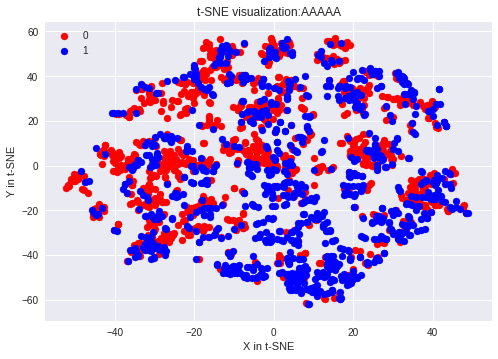

In [35]:
from sklearn.manifold import TSNE

X,y = get_dataset(DATASET_UCI, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = True, random_state = 41) #DATASET_KAGGLE DATASET_UCI
df_data = X; df_data['Class'] = y
show_t_SNE(df_data, 1000, 'AAAAA' )

In [0]:
#PCA Graphs
X,y = get_dataset(DATASET_KAGGLE, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = True, random_state = 41)
#X,y = get_dataset(DATASET_UCI, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 6169, encode_pca = True, random_state = 41)  # k=2%,drop=6636-(23364/100)*k
#X,y = get_dataset(DATASET_UCI, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = True, random_state = 41)

df_data = X; df_data['Class'] = y
show_3d_PCA(df_data, 'Kaggle dataset - 0.2% frauds')
#show_3d_PCA(df_data, 'UCI dataset - 2% frauds')
#show_3d_PCA(df_data, 'UCI dataset - 25% frauds')

NOTES

---



---



In [0]:
k = 2
x = 6636 - (23364/100)*k
print(x)

In [0]:
download_dfResults(dfResults, 'UC_{0:0.2f}_V23.csv'.format(DATA_FRAC_NORMAL))  

In [0]:
#X.describe()
#np.isfinite(X).all()
#X.isnull().values.any()
#X.max().to_frame()
#sklearn.utils.assert_all_finite(df_data['Class'])

In [41]:
#----TESTING---
X,y = get_dataset(DATASET_UCI, n_frac = DATA_FRAC_NORMAL, frauds_to_drop = 0, encode_pca = False, random_state = 41)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

# We'll need some metrics to evaluate our models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit( X_train, y_train )
y_pred = classifier.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
#scoresRF = cross_val_score( classifier, X_train, y_train, cv=10)
print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))
print( 'RF F1 :', f1_score(y_test, y_pred) )

#-------------- 
# kernel SVM 
#--------------
from sklearn.svm import SVC
classifier1 = SVC(kernel="linear", C=0.025)
classifier1.fit( X_train, y_train )
y_pred = classifier1.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for kernel-SVM = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
#scoresSVC = cross_val_score( classifier1, X_train, y_train, cv=10)
#print("Mean kernel-SVM CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresSVC.mean(), scoresSVC.std() ))
print( 'SVC F1 :', f1_score(y_test, y_pred) )

Loaded data : (30000, 24)   fract: 1.0
0    23364
1    6636 
Name: Class, dtype: int64
Accuracy on Test Set for RandomForest = 0.80
Mean RandomForest CrossVal Accuracy on Train Set 0.81, with std=0.01
RF F1 : 0.4001976284584981
Accuracy on Test Set for kernel-SVM = 0.80
SVC F1 : 0.3454443823365009
